In [1]:
projPath_load='/home/alvaro/notebook/jupyterenv/bin/TFM/CODIGO/test_tfm_code_test/dfA_n2_zone_aturat_index.csv'

In [2]:
projPath_save='/home/alvaro/notebook/jupyterenv/bin/TFM/CODIGO/test_tfm_code_test/'

In [3]:
month = '202206'
darsena = '_DM'

In [4]:
buffer_basin = 20 #m
buffer_dock = 30 #m
buffer_basin1 = 150 #m

min_points = 10

In [5]:
import numpy as np
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt

In [6]:
%matplotlib notebook

In [7]:
moll_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/MollsDarsenaMorrot_noTalo.shp')
dm_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/DarsenaMorrot.shp')

In [8]:
dm_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
dm_buffer = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin).to_crs(4326))
dm_buffer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
dm_buffer_z2 = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin1).to_crs(4326))
dm_buffer_z2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
moll_buffer = gpd.GeoDataFrame(geometry = moll_map.to_crs(32631).buffer(buffer_dock, cap_style = 2,join_style = 2).to_crs(4326))

<IPython.core.display.Javascript object>


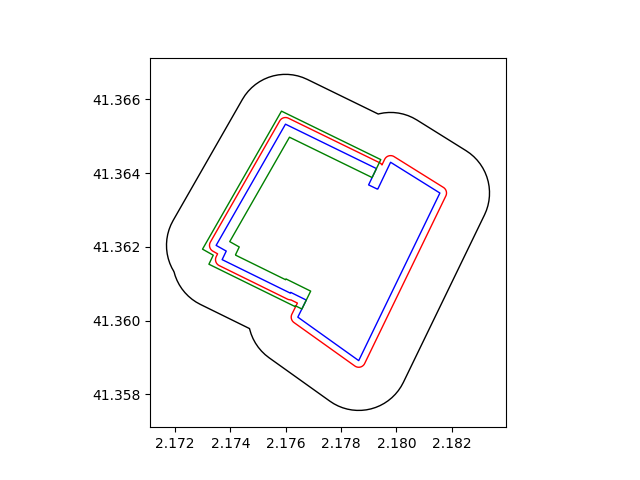

<AxesSubplot:>

In [12]:
fig, ax = plt.subplots()
dm_map.plot(ax = ax, fc = 'none', ec = 'blue')
dm_buffer.plot(ax = ax, fc = 'none', ec = 'red')
moll_buffer.plot(ax = ax, fc = 'none', ec = 'green')
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')

# Load Data

In [13]:
dfA_n2=pd.read_csv(projPath_load)

In [14]:
len(dfA_n2)

57339

ADD NEW COLUMN

In [15]:
dfA_n2['real_atur']=0

In [16]:
dfA_n2.head()

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,shiptype,draught,to_bow,to_stern,to_starboard,to_port,imo,zone,entsort,real_atur
0,2022-06-01 01:03:59,247383500,0,-6.0,34.0,2.17667,41.35834,26.1,25.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
1,2022-06-01 01:04:10,247383500,0,-7.0,33.0,2.17678,41.35849,25.9,25.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
2,2022-06-01 01:04:20,247383500,0,-7.0,33.0,2.17686,41.35864,25.5,24.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
3,2022-06-01 01:04:30,247383500,0,-8.0,33.0,2.17695,41.35878,25.3,24.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
4,2022-06-01 01:04:40,247383500,0,-9.0,32.0,2.17704,41.35892,25.1,23.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0


# FUNCTIONS DEFINITION

Normal case

In [17]:
def realparado (dft):
    df=dft.copy()
    df['parado'] = (df['speed'] == 0)
    df['consecutivos'] = (df['parado'] != df['parado'].shift()).cumsum()
    dif = df.loc[df['speed']==0].groupby('consecutivos')
    grupos = dif['time_stamp'].apply(lambda x: pd.to_datetime(x.iloc[-1]) - pd.to_datetime(x.iloc[0]))
    grupos_filtrados = grupos[grupos >= pd.Timedelta(minutes = 10)]
    indices = grupos_filtrados.index.values
    for consecutivo in indices:
        df.loc[df['consecutivos'] == consecutivo, 'real_atur'] = 1
    dft['real_atur'] = df['real_atur']
    dft['real_atur'] = medfilt(df['real_atur'], kernel_size = 77)

Case when GPS signal error appears

In [18]:
def realparado1 (dft):
    df=dft.copy()
    df['speed_window'] = df['speed'].rolling(window=5).mean()
    df['parado'] = (df['speed_window'] < 1)
    df['consecutivos'] = (df['parado'] != df['parado'].shift()).cumsum()
    dif = df.loc[df['speed_window']<1].groupby('consecutivos')
    grupos = dif['time_stamp'].apply(lambda x: pd.to_datetime(x.iloc[-1]) - pd.to_datetime(x.iloc[0]))
    grupos_filtrados = grupos[grupos >= pd.Timedelta(minutes = 10)]
    indices = grupos_filtrados.index.values
    for consecutivo in indices:
        df.loc[df['consecutivos'] == consecutivo, 'real_atur'] = 1
    dft['real_atur'] = df['real_atur']
    dft['real_atur'] = medfilt(df['real_atur'], kernel_size = 87)

Final Function

In [19]:
def realparado2 (df):
    realparado(df)
    l1 = len(df['real_atur'])
    l2 = len(df.loc[df['real_atur']==1,:])
    l3 = len(df.loc[df['speed']==1,:])/len(df['speed'])
    if (l2/l1 < 0.3) or (l3 > 0.12):
        df['real_atur']=0
        realparado1(df)
    else:
        pass

In [20]:
def realparado4 (dfA1):
    df = dfA1.loc[(dfA1['entsort']=='ent')|(dfA1['entsort']=='sort') ,:].copy()
    dfAt = dfA1.copy()
    for elm in range (0, df.shape[0], 2):
        r1=df.index[elm]
        r2=df.index[elm+1]
        dtt = dfAt.loc[r1:r2,:].copy()
        realparado2(dtt)
        tt = dtt.loc[dtt['real_atur']==1,:].index
        dfAt.loc[tt,['real_atur']]=1
    dfA_n2.loc[dfAt.loc[dfAt['real_atur']==1, :].index,['real_atur']]=1

# GROUP BY

In [22]:
dfAmmsi=dfA_n2.groupby('mmsi')

# LAUNCH FUNCTION

In [23]:
dfAmmsi.apply(realparado4)

/home/alvaro/notebook/jupyterenv/lib/python3.6/site-packages/scipy/signal/signaltools.py:1396: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


""


In [24]:
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

36734

In [25]:
dfA_n2.head()

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,shiptype,draught,to_bow,to_stern,to_starboard,to_port,imo,zone,entsort,real_atur
0,2022-06-01 01:03:59,247383500,0,-6.0,34.0,2.17667,41.35834,26.1,25.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
1,2022-06-01 01:04:10,247383500,0,-7.0,33.0,2.17678,41.35849,25.9,25.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
2,2022-06-01 01:04:20,247383500,0,-7.0,33.0,2.17686,41.35864,25.5,24.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
3,2022-06-01 01:04:30,247383500,0,-8.0,33.0,2.17695,41.35878,25.3,24.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0
4,2022-06-01 01:04:40,247383500,0,-9.0,32.0,2.17704,41.35892,25.1,23.0,2022-06-01,...,74,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,0


New

In [26]:
dfAmmsi['real_atur'].describe()

,count,mean,std,min,25%,50%,75%,max
mmsi,,,,,,,,
209115000,1673.0,0.684399,0.464894,0.0,0.0,1.0,1.0,1.0
210117000,114.0,0.342105,0.476509,0.0,0.0,0.0,1.0,1.0
247219400,16251.0,0.802966,0.397770,0.0,1.0,1.0,1.0,1.0
247243600,7499.0,0.636218,0.481119,0.0,0.0,1.0,1.0,1.0
247383300,7102.0,0.545199,0.497988,0.0,0.0,1.0,1.0,1.0
247383400,12831.0,0.696049,0.459980,0.0,0.0,1.0,1.0,1.0
247383500,5890.0,0.342445,0.474568,0.0,0.0,0.0,1.0,1.0
247383600,5979.0,0.486703,0.499865,0.0,0.0,0.0,1.0,1.0


In [27]:
dfAmmsi['real_atur'].apply(lambda x: (x == 1).sum())

mmsi
209115000     1145
210117000       39
247219400    13049
247243600     4771
247383300     3872
247383400     8931
247383500     2017
247383600     2910
Name: real_atur, dtype: int64

# SAVE DATA

In [28]:
dfA_n2.to_csv(projPath_save +'dfA_n2_zone_aturat_index_realatur.csv', index = False, columns = ['time_stamp','mmsi','status','turn','speed','lon','lat','course','heading', 'day','shipname','shiptype','draught','to_bow','to_stern', 'to_starboard','to_port', 'imo', 'zone', 'entsort', 'real_atur'])